In [1]:
%config IPCompleter.greedy=True
%pylab inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


# k-NN Project: Music Genre Prediction

author: andrew.pouret@berkeley.edu, matthieujacquand@berkeley.edu

## Dataset

Dataset : https://www.kaggle.com/carlthome/gtzan-genre-collection 

We've extracted our own features from the original audio file dataset.

![datset-extraction-figure](./docs/DatasetCreation.jpg)

In [2]:
dataset_file = "datasets/data-v1.csv"

df = pd.read_csv(dataset_file, sep=",")

# Data Descriptive Statistics

## Summaries and Analysis

Describing the whole dataset by mean, interquartiles, count, standard deviation, min and max values.

In [3]:
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.380795,0.124698,1883.001208,1865.303842,3878.803772,0.101184,-162.754063,121.255273,-29.199931,54.109434,...,-7.320438,3.900521,-2.205811,-2.243190,1.619559,-5.134632,3.043665,-6.634297,5.002622,-7.852236
std,0.082699,0.062342,522.242739,339.144108,1096.400581,0.039370,95.151859,23.111192,20.168244,16.110998,...,5.512331,5.395750,4.365042,3.977097,3.694564,3.984223,4.333503,4.096735,4.316616,4.287511
min,0.171805,0.005014,549.065530,796.514455,710.220705,0.021877,-556.024780,42.361320,-99.755829,-3.247742,...,-32.414146,-14.018186,-20.763159,-16.360909,-12.323302,-19.637094,-12.697938,-18.963448,-13.177314,-22.937521
25%,0.321059,0.082679,1461.113254,1643.098517,3034.883732,0.071043,-213.648769,104.958897,-42.612360,45.396466,...,-11.082822,0.603397,-5.172873,-4.874094,-0.737182,-7.606263,0.300295,-9.524103,2.242899,-10.705755
50%,0.385390,0.116670,1926.222388,1943.105990,4064.821254,0.097405,-138.674522,118.840340,-30.713336,54.597818,...,-7.538498,4.457320,-2.305679,-2.279468,1.757869,-5.469918,3.286095,-6.899161,5.105744,-8.184787
75%,0.439446,0.167502,2277.180673,2110.350537,4748.075456,0.128231,-95.242519,135.433762,-17.951447,64.680765,...,-3.929274,7.729157,0.444397,0.385467,4.065663,-2.710800,5.842021,-4.012571,8.109790,-5.197460
max,0.667248,0.378549,3369.517356,2611.325445,6268.003765,0.257681,15.127309,197.522858,55.721581,98.046173,...,11.871216,17.391365,13.880814,10.114944,17.297344,9.187266,22.280184,11.137421,22.338120,10.675509


We have continuous numerical features only and very different scales.

We therefore need to scale the data if we use algorithms such as KNN that uses distances.

In [4]:
df.groupby("label").describe()

chroma_stft                                                    \
                count      mean       std       min       25%       50%   
label                                                                     
blues           100.0  0.343227  0.058931  0.233692  0.292326  0.341920   
classical       100.0  0.264589  0.044916  0.176353  0.235109  0.261854   
country         100.0  0.345596  0.041632  0.221800  0.318387  0.349099   
disco           100.0  0.418476  0.047192  0.222056  0.391103  0.420694   
hiphop          100.0  0.456589  0.047641  0.343888  0.426723  0.456683   
jazz            100.0  0.297616  0.054880  0.171805  0.264486  0.286398   
metal           100.0  0.485472  0.052178  0.344913  0.448991  0.485387   
pop             100.0  0.397489  0.056778  0.226208  0.356170  0.402205   
reggae          100.0  0.409579  0.059100  0.273363  0.372328  0.397364   
rock            100.0  0.389316  0.045168  0.259164  0.360462  0.394556   

                                rmse            ...     mfcc19             \
                75%       max  count      mean  ...        75%        max   
label                                           ...                         
blues      0.390246  0.466403  100.0  0.129791  ...   6.492363  11.237574   
classical  0.284500  0.437762  100.0  0.040913  ...   3.092124  15.061405   
country    0.376250  0.441659  100.0  0.120016  ...   6.853879  12.676275   
disco      0.443128  0.569531  100.0  0.130006  ...   8.594055  14.059900   
hiphop     0.484775  0.587268  100.0  0.169843  ...   8.625050  22.338120   
jazz       0.330663  0.442270  100.0  0.082410  ...   6.951112  16.488413   
metal      0.518324  0.642209  100.0  0.147867  ...  10.034965  13.598536   
pop        0.437702  0.521142  100.0  0.188373  ...  10.544102  15.758379   
reggae     0.448954  0.667248  100.0  0.116101  ...   5.452219  13.288021   
rock       0.420699  0.492719  100.0  0.121665  ...   7.940282  12.904313   

          mfcc20                                                        \
           count       mean       std        min        25%        50%   
label                                                                    
blues      100.0  -8.222616  5.139506 -22.937521 -10.792815  -7.633846   
classical  100.0  -2.797445  4.304100 -12.353147  -5.922751  -3.435926   
country    100.0  -9.289553  3.555105 -17.309389 -11.876318  -9.747382   
disco      100.0  -8.660215  3.184145 -15.856296 -10.905391  -9.185828   
hiphop     100.0  -8.204685  3.695935 -15.875212 -10.761899  -8.679704   
jazz       100.0  -6.441251  4.257621 -16.408215  -9.224790  -6.445479   
metal      100.0 -10.563572  3.521345 -17.667761 -12.787441 -10.739081   
pop        100.0  -7.233187  2.922915 -13.816062  -8.826675  -7.465171   
reggae     100.0  -7.343275  3.563766 -18.587709  -8.859087  -7.258358   
rock       100.0  -9.766561  3.121559 -15.749303 -11.652519 -10.329604   

                                
                75%        max  
label                           
blues     -4.517999   3.000812  
classical -0.290962  10.675509  
country   -6.808592  -0.632099  
disco     -6.527245   2.116452  
hiphop    -5.420062   7.931248  
jazz      -3.437631   7.706425  
metal     -8.269789  -0.704288  
pop       -6.028513   1.402305  
reggae    -5.320831   3.891456  
rock      -8.332700   0.552947  

[10 rows x 208 columns]

The dataset has 26 columns and 10 music genres (groups).

In terms of the chroma_stft feature we find that metal has the highest mean, interquartiles and median of the groups, and that classical has the lowest ones. Compared to classical and jazz music, the  metal and hiphop genres are a lot more spreadout in terms of chroma_stft (standard deviation), which may have an influence on how well we detect the metal and hiphop genres.


In terms of the mffc20 feature we find that metal has the lowest mean (was the highest mean for chroma_stft) and median of the groups whereas that classical has the highest ones. Blues has the larget standard deviation and pop has the lowest for the mfcc20.


Overall, some genres seem to stick out but it's hard to find a pattern between genres by looking at 26 different features.


D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


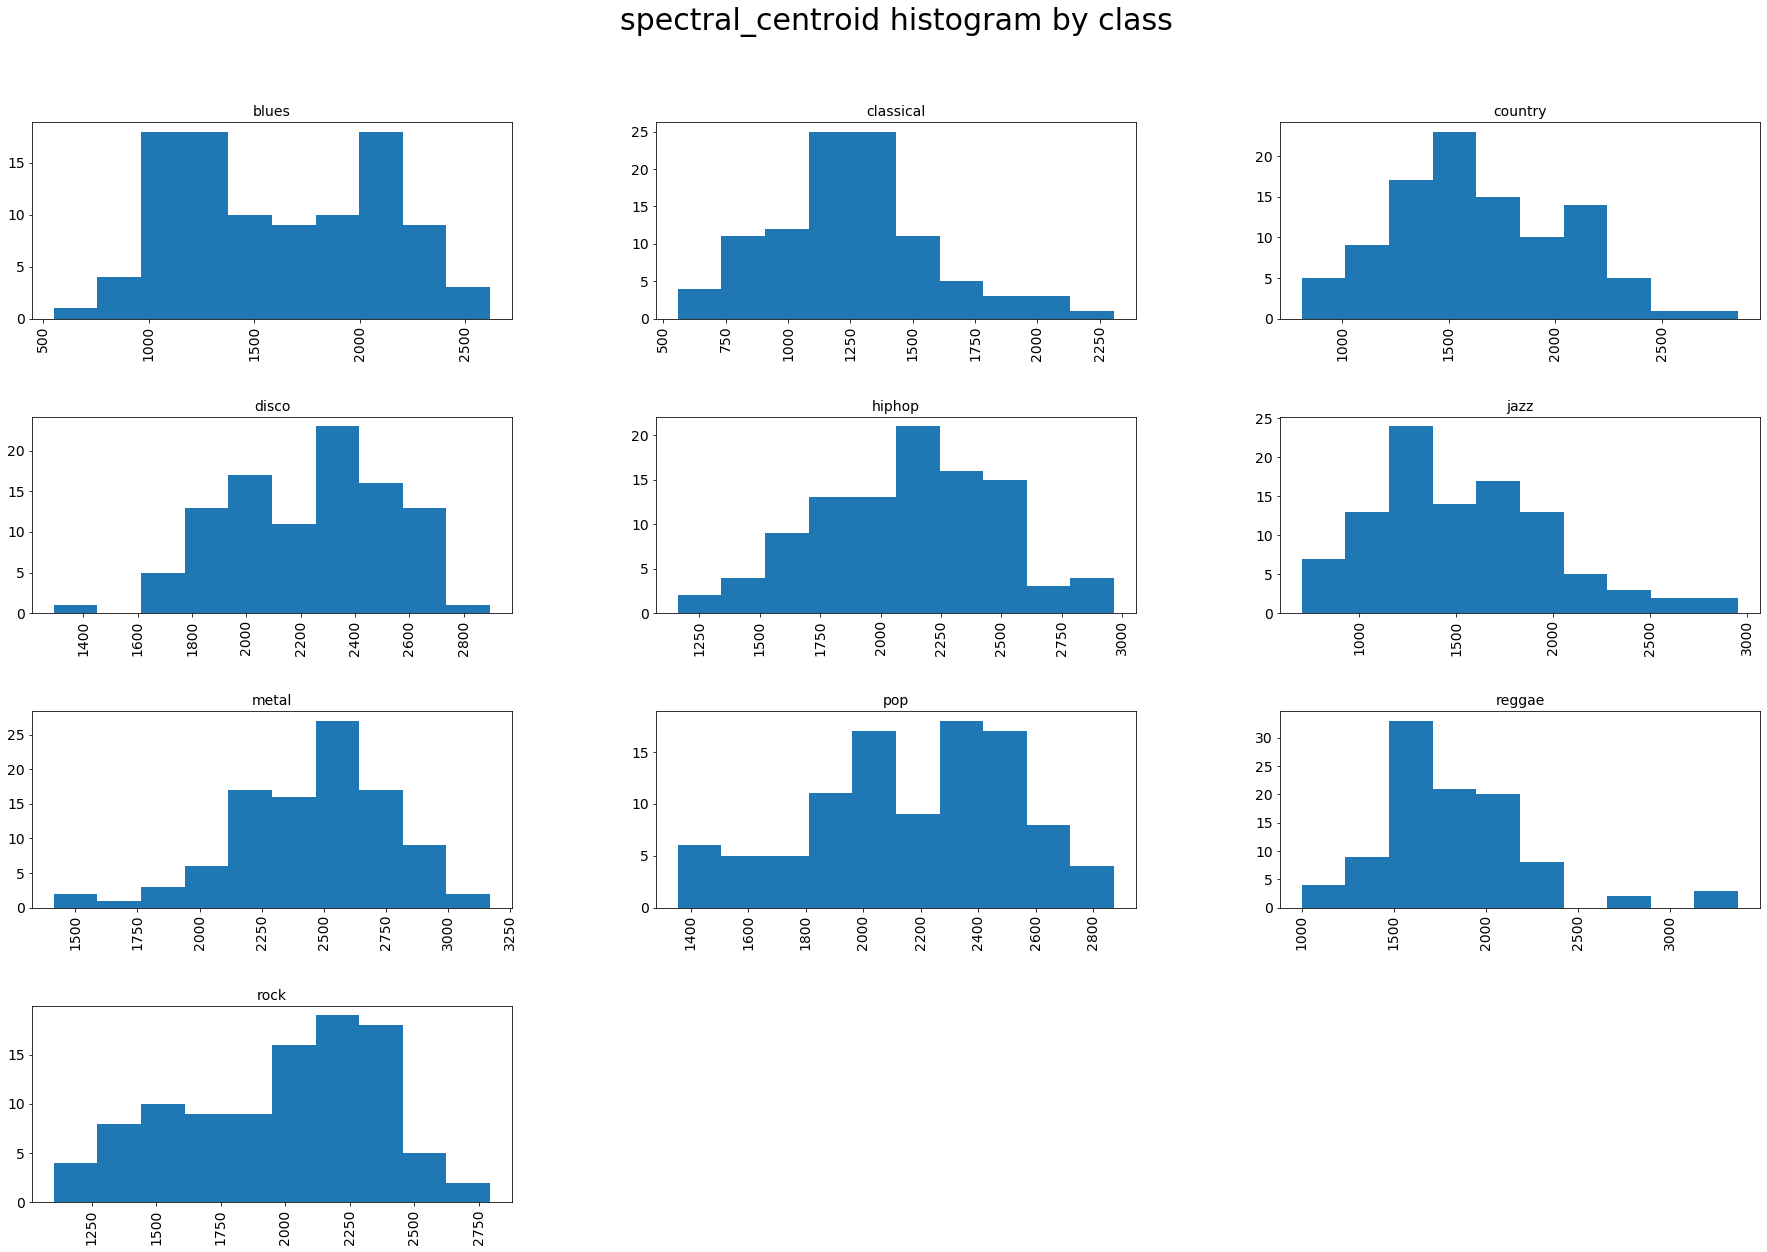

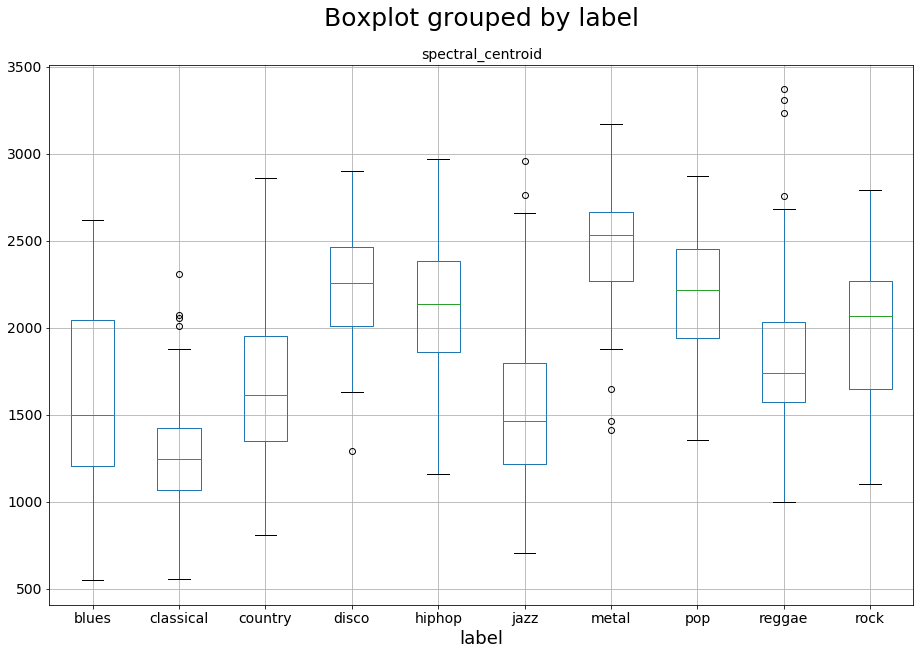

In [5]:
from ml_toolbox import plot_histograms, plot_boxes

plot_histograms(df, "spectral_centroid")
plot_boxes(df, "spectral_centroid")

The range of the Spectral Centraoid within a genre is large (a difference of 1000-2000 at least between min and max values of a genre), but 50% of songs within a "genre" are grouped together on a much smaller ranges.

The median for every genre is centered over except for reggae and metal. 

In terms of histogram, some genres like hiphop are, jazz or metal follow a positively or negatively skewed distribution wheras the others don't follow a normal distribution. 

However classical, reggae and metal have a lot of outliers. 

Classical in terms of the spectral centroid has 50% of its invididuals with a lower value than every other genre except (Jazz). Which may have an influence on how well classical music is detected..


We find a strong correlation between features, which is quite logicial since each feature are spectral properties obtained by some signal processing methods that perhaps.

It would be unwise to use a model such as Naive Bayes that requires features to be independant.

# k-NN setup 

As we saw earlier, the dataset features are numerical and continuous.

Our dataset doesn't contain any null values because we've extracted our own features from the audio files.

The scale of the features vary, so we need to scale our dataset before applying our KNN to the dataset.

In [6]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["label", "filename"], axis=1).values

std_scale = StandardScaler().fit(X) # applying feature scaling because KNN uses euclidean distance to ocompute clusters

X = std_scale.transform(X)

y = df["label"].values

We've detected some outliers earlier on in our boxplots. However we choose not to remove them at the moment. We could try and remove them and see how well our model performs.

# K-NN Implementation

Our goal here is to detect the music genres.

### First K-NN - 11 features

In [7]:
#X and Y creation
X = df[['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5']].values

y = df[['label']].values

#data splitting
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
scores = {} # accuracy of scores bewteen model versions

Train set Accuracy: 0.71
Test set Accuracy: 0.49
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.53      0.64      0.58        28
   classical       0.75      0.90      0.82        20
     country       0.33      0.48      0.39        21
       disco       0.35      0.55      0.43        20
      hiphop       0.62      0.38      0.47        21
        jazz       0.50      0.55      0.52        20
       metal       0.80      0.63      0.71        19
         pop       0.38      0.33      0.36        15
      reggae       0.43      0.19      0.26        16
        rock       0.27      0.15      0.19        20

    accuracy                           0.49       200
   macro avg       0.50      0.48      0.47       200
weighted avg       0.50      0.49      0.48       200



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


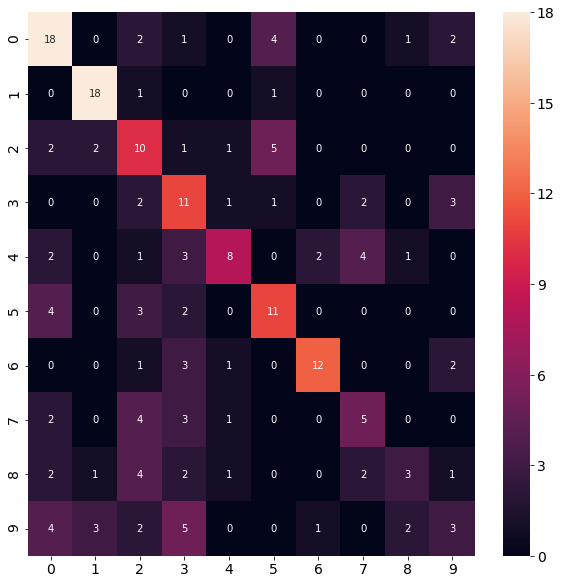

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 3
knn_v0 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v0.fit(X_train, y_train.ravel())

train_score = knn_v0.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v0.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)

ypred = knn_v0.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

The accuracy here for 3 neighbors is very low even on the train set. Let's add some features and see what happens

### Second K-NN - 24 features

In [10]:
#X and Y creation
X = df[['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16',
                'mfcc17','mfcc18','mfcc19','mfcc20']].values 
y = df[['label']].values


#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train set Accuracy: 0.77
Test set Accuracy: 0.55
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.55      0.80      0.65        15
   classical       0.80      0.91      0.85        22
     country       0.29      0.53      0.37        15
       disco       0.29      0.50      0.36        20
      hiphop       0.47      0.35      0.40        20
        jazz       0.79      0.48      0.59        23
       metal       0.83      0.62      0.71        24
         pop       0.57      0.57      0.57        21
      reggae       0.77      0.56      0.65        18
        rock       0.56      0.23      0.32        22

    accuracy                           0.55       200
   macro avg       0.59      0.55      0.55       200
weighted avg       0.61      0.55      0.55       200



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


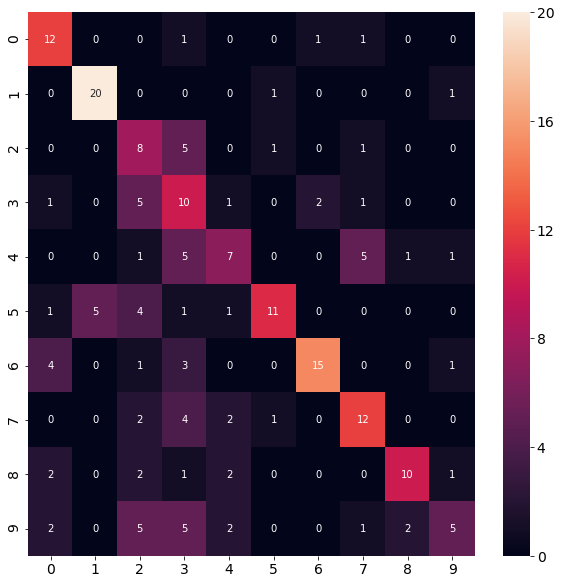

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 3
knn_v1 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v1.fit(X_train, y_train.ravel())

train_score = knn_v1.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v1.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)


ypred = knn_v1.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

By adding 15 features, without changing the number of neighbors, we've increased the accuracy on the test set by 10%. Let's now optimize our model by applying grid search to find the best number of neighbors.

### Third K-NN - Finding best hyperparameters using GridSearch Cross Validation

In [12]:
from sklearn.model_selection import GridSearchCV

k_range = [i for i in range(1, 20)]
grid_params = {
    "n_neighbors": k_range,
}

knn_v2_gs = GridSearchCV(KNeighborsClassifier(),grid_params, cv=3,)
knn_v2_gs_results = knn_v2_gs.fit(X_train, y_train.ravel())

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
knn_v2_gs_results.best_params_

{'n_neighbors': 7}

Interestingly 9 is the best number of neighbors.

Train set Accuracy: 0.71
Test set Accuracy: 0.60
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.67      0.67      0.67        15
   classical       0.78      0.95      0.86        22
     country       0.38      0.67      0.49        15
       disco       0.32      0.50      0.39        20
      hiphop       0.62      0.40      0.48        20
        jazz       0.92      0.48      0.63        23
       metal       0.77      0.71      0.74        24
         pop       0.68      0.62      0.65        21
      reggae       0.71      0.67      0.69        18
        rock       0.44      0.36      0.40        22

    accuracy                           0.60       200
   macro avg       0.63      0.60      0.60       200
weighted avg       0.64      0.60      0.60       200



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


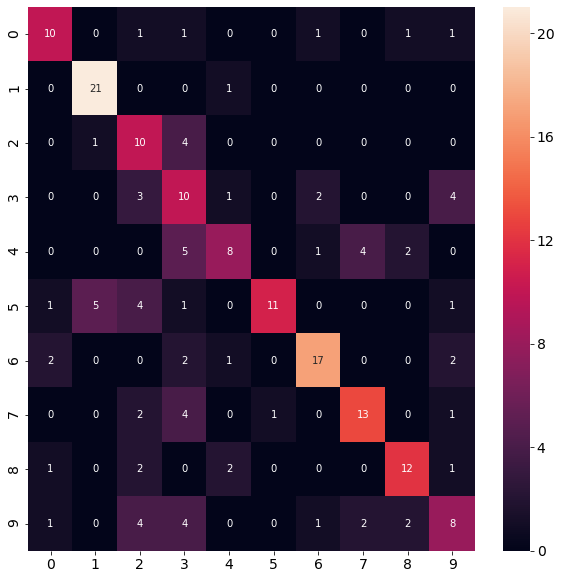

In [14]:
knn_v2 = knn_v2_gs_results.best_estimator_

train_score = knn_v2.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v2.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)


ypred = knn_v2.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

The grid search however did not seem to improve the overall accuracy however it is interesting that find that the manhattan distance works slightly better than the euclidean distance.

However compared the second model and this one the "blues" predictions accuracy decreased and some other classes predictions such as metal increased.

### Fourth K-NN - Finding the best features

In [15]:
#X and Y creation
X = df[['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16',
                'mfcc17','mfcc18','mfcc19','mfcc20']].values 
y = df[['label']].values

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

y_encoded = encoder.transform(y)

#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.13369124 0.02992952 0.03057037 0.04802064 0.0748617  0.02542158
 0.02224466 0.03019159 0.04696846 0.042658   0.04187449 0.02217694
 0.02586028 0.03460627 0.04604648 0.0210394  0.03180051 0.04550023
 0.03142874 0.04548251 0.02518138 0.02351391 0.03129479 0.03041298
 0.03376397 0.02545935]
[15 11  6 21 20  5 25 12  1  7 23  2 22 18 16 24 13 10  9 19 17 14  8  3
  4  0]


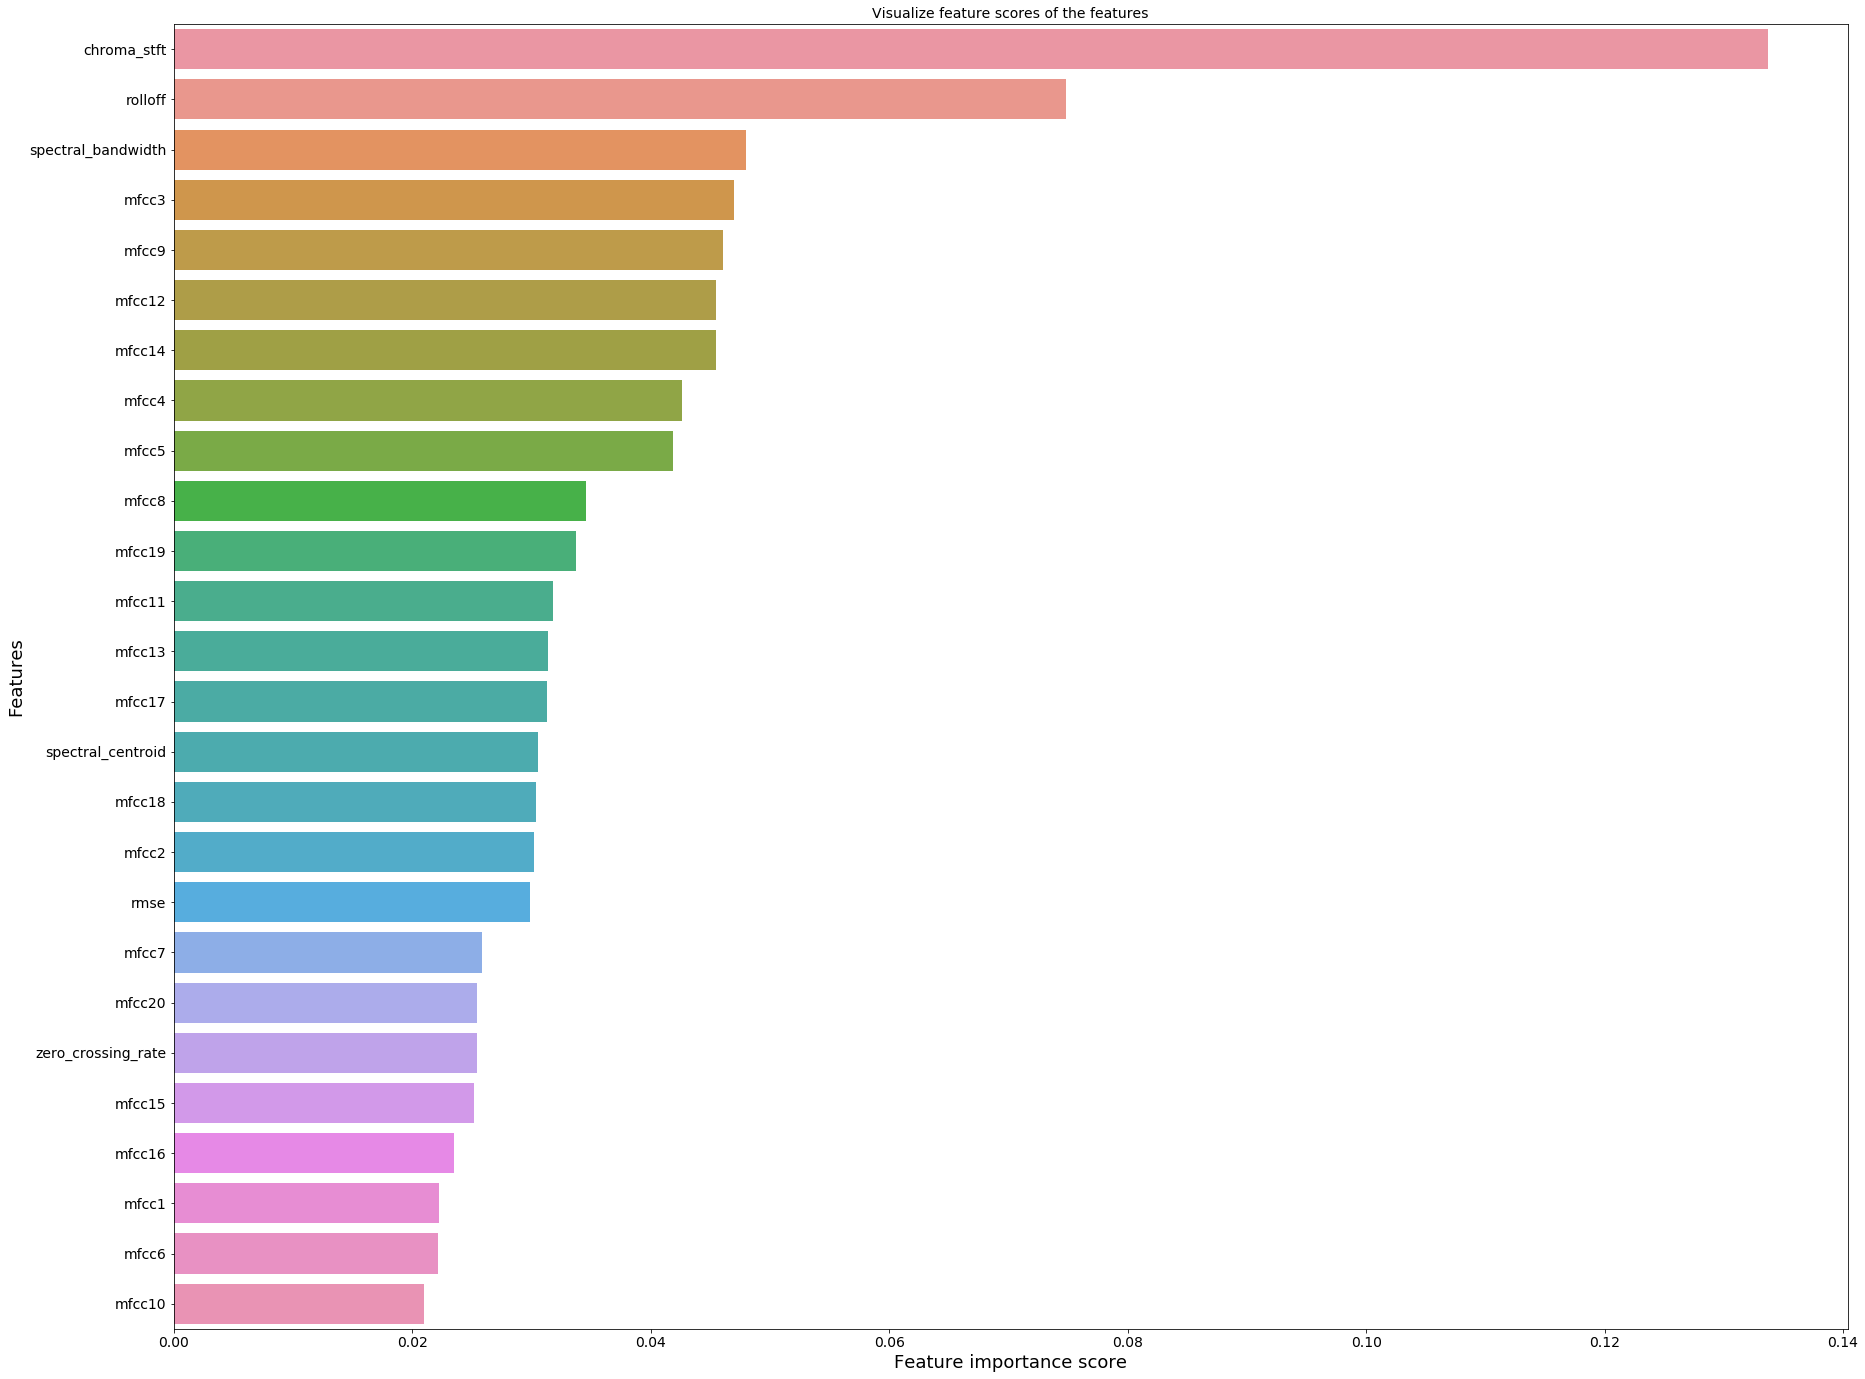

In [16]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, y_train.ravel())
rf.feature_importances_
print(rf.feature_importances_)
sorted_idx = rf.feature_importances_.argsort()

print(sorted_idx)

# view the feature scores
feature_scores = pd.Series(rf.feature_importances_, index=['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16',
                'mfcc17','mfcc18','mfcc19','mfcc20']).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df.T)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

The `rolloff` and `chroma_stft` seem to be the most important importance to build the random forest trees. 

We'll train several model using the n most important features and cross validation to determine the best number of top features.

In [17]:
def gridsearchcv_train_knn(X, y):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(y)

    y_encoded = encoder.transform(y)

    #data splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle = True)

    # Data normalization
    scaler = StandardScaler()
    scaler.fit(X)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    k_range = [i for i in range(1, 20)]
    grid_params = {
        "n_neighbors": k_range,
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    }

    knn_v3 = KNeighborsClassifier(n_neighbors=9)
    
    knn_v3.fit(X_train, y_train.ravel())
    
    train_score = knn_v3.score(X_train, y_train.ravel()) # accuracy
    test_score = knn_v3.score(X_test, y_test.ravel()) # accuracy
    
    return {"train_accuracy": train_score, "test_accuracy": test_score, "number_features": X.shape[1]} 


y = df[['label']].values

results = []
features_range = range(2, len(feature_scores.index))
for i in features_range:
    X = df[list(feature_scores.index)[:i]]
    scores = gridsearchcv_train_knn(X, y.ravel())
    results.append(scores)
    

Best score: 0.63, with 20 features


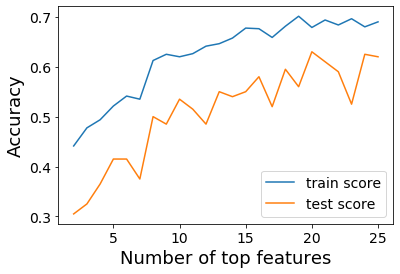

In [19]:
%matplotlib inline

train_score_results = [r["train_accuracy"] for r in results]
test_score_results = [r["test_accuracy"] for r in results]
nb_feature_results = [r["number_features"] for r in results]

plt.plot(features_range, train_score_results, label="train score")
plt.plot(features_range, test_score_results, label="test score")



max_result = max(test_score_results)

for i in range(len(test_score_results)):
    if test_score_results[i] == max_result:
        best_nb_features = nb_feature_results[i]

print(f"Best score: {max_result}, with {best_nb_features} features")

        
plt.xlabel('Number of top features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Finally we found that the best model is 9-NN trained on 24 features (vs 26 total).